In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [60]:
# Creating the 'multiplier' dataframe
multiplier_values = {
    '26': [24, 47, 73, 77, 12],
    '27': [70, 82, 89, 83, 27],
    '28': [41, 87, 100, 85, 52],
    '29': [21, 80, 90, 79, 15],
    '30': [60, 35, 17, 55, 30]
}
multiplier = pd.DataFrame(multiplier_values, index=['G', 'H', 'I', 'J', 'K'])

# Creating the 'hunters' dataframe
hunters_values = {
    '26': [2, 3, 4, 5, 2],
    '27': [4, 5, 5, 5, 3],
    '28': [3, 5, 8, 5, 4],
    '29': [2, 5, 7, 5, 2],
    '30': [4, 3, 2, 4, 3]
}
hunters = pd.DataFrame(hunters_values, index=['G', 'H', 'I', 'J', 'K'])


In [61]:
profit_0 = multiplier / hunters

In [62]:
mean_profit0 = profit_0.values.flatten().mean()
max_profit_0 = profit_0.values.flatten().max()
med_profit_0 = np.median(profit_0.values.flatten())


print(f'Maximum Profit: {max_profit_0} \n Mean Profit: {mean_profit0} \n Median Profit: {med_profit_0}')

Maximum Profit: 18.25 
 Mean Profit: 13.590285714285715 
 Median Profit: 13.75


(array([1., 1., 2., 2., 2., 3., 2., 3., 5., 4.]),
 array([ 6.   ,  7.225,  8.45 ,  9.675, 10.9  , 12.125, 13.35 , 14.575,
        15.8  , 17.025, 18.25 ]),
 <BarContainer object of 10 artists>)

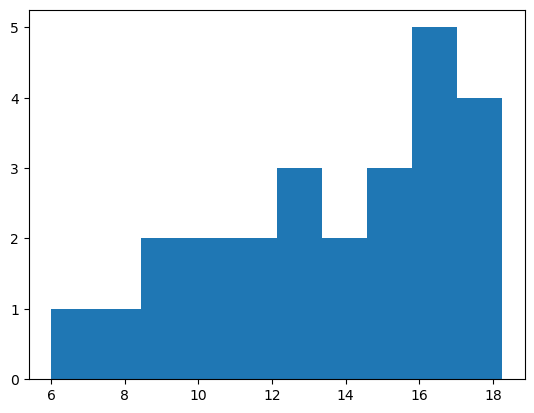

In [63]:
plt.hist(profit_0.values.flatten())

In [90]:
# Flatten the dataframes to create a list of all possible combinations
profits_flat = profit_0.unstack().reset_index()
profits_flat.columns = ['Number', 'Row', 'profit_0']

# Creating the combination column as RowNumber (e.g., G26)
profits_flat['Combination'] = profits_flat['Row'] + profits_flat['Number']

# Selecting only the required columns and sorting by profit_0
profits_flat = profits_flat[['Combination', 'profit_0']].sort_values(by='profit_0', ascending=False)

# Flatten the 'multiplier' and 'hunters' dataframes for merging
multipliers_flat = multiplier.unstack().reset_index(name='Multiplier_Value')
hunters_flat = hunters.unstack().reset_index(name='Hunters_Value')
multipliers_flat['Combination'] = multipliers_flat['level_1'] + multipliers_flat['level_0']
hunters_flat['Combination'] = hunters_flat['level_1'] + hunters_flat['level_0']

# Merge with 'profits_flat' dataframe
profits_flat = profits_flat.merge(multipliers_flat, left_on='Combination', right_on='Combination')
profits_flat = profits_flat.merge(hunters_flat, left_on='Combination', right_on='Combination')

profits_flat = profits_flat[['Combination', 'profit_0', 'Multiplier_Value', 'Hunters_Value']]

In [67]:
def add_purchase_P(profits_flat, probability_buy=2/3, n_trials=10000, index=0):
    purchase_results = np.zeros(len(profits_flat))  # Initialize an array to hold the purchase results

    # Perform the Monte Carlo simulation
    for _ in range(n_trials):
        purchased = 0
        for idx in range(len(profits_flat)):
            # Stop the trial if already purchased 3 items
            if purchased >= 3:
                break
            # If the purchase is successful (based on probability_buy), mark it as 1
            if np.random.rand() < probability_buy:
                purchase_results[idx] += 1
                purchased += 1

    # Calculate the purchase probabilities
    profits_flat[f'purchase_{index}'] = 100 * purchase_results / n_trials

    return profits_flat


In [89]:
def run_monte_carlo_simulation(profits_flat, probability_buy, n_trials, max_purchases):
    # Add purchase probability columns and recalculate profit after each purchase
    for i in range(max_purchases):
        purchase_column = f'purchase_{i}'
        profits_flat[purchase_column] = 0

        for _ in range(n_trials):
            purchased = 0
            for idx in profits_flat.index:
                if purchased >= 3:  # Limit of purchases per trial
                    break
                if np.random.rand() < probability_buy:
                    profits_flat.at[idx, purchase_column] += 1
                    purchased += 1

        # Calculate purchase probabilities
        profits_flat[purchase_column] = profits_flat[purchase_column] / n_trials

        # Recalculate profit
        profit_column = f'profit_{i+1}'
        cumulative_purchases = profits_flat[[f'purchase_{j}' for j in range(i+1)]].sum(axis=1)
        profits_flat[profit_column] = profits_flat['Multiplier_Value'] / (profits_flat['Hunters_Value'] + cumulative_purchases)

        # Sort by the new profit column
        profits_flat = profits_flat.sort_values(by=profit_column, ascending=False)

    return profits_flat

In [95]:
profits_flat = run_monte_carlo_simulation(profits_flat, probability_buy=0.5, n_trials=1000, max_purchases=4)

In [96]:
profits_flat

,Combination,profit_0,Multiplier_Value,Hunters_Value,purchase_0,profit_1,purchase_1,profit_2,purchase_2,profit_3,purchase_3,profit_4
4,J28,17.000000,85,5,0.021,16.928899,0.499,15.398551,0.444,14.252180,0.077,14.070518
1,I27,17.800000,89,5,0.355,16.619981,0.414,15.427284,0.517,14.158447,0.045,14.057811
8,J29,15.800000,79,5,0.487,14.397667,0.024,14.334966,0.028,14.262502,0.126,13.945278
10,J26,15.400000,77,5,0.509,13.977128,0.015,13.939175,0.020,13.888889,0.013,13.856397
7,H29,16.000000,80,5,0.515,14.505893,0.044,14.391078,0.047,14.270425,0.176,13.836043
2,G27,17.500000,70,4,0.010,17.456359,0.533,15.408320,0.494,13.897161,0.031,13.812155
6,H27,16.400000,82,5,0.049,16.240840,0.353,15.179563,0.111,14.873934,0.472,13.700919
0,I26,18.250000,73,4,0.110,17.761557,0.494,15.855778,0.480,14.358773,0.270,13.634666
5,J27,16.600000,83,5,0.240,15.839695,0.184,15.302360,0.338,14.404721,0.351,13.577621
3,H28,17.400000,87,5,0.448,15.969163,0.255,15.255129,0.257,14.597315,0.488,13.492556


In [71]:
profits_flat = add_purchase_P(profits_flat, probability_buy=2/3, n_trials=10000, index=0)
profits_flat['profit_1'] = profits_flat['Multiplier_Value'] / (profits_flat['Hunters_Value'] + profits_flat['purchase_0'])
profits_flat = profits_flat.sort_values(by='profit_1', ascending=False)


In [73]:
profits_flat = add_purchase_P(profits_flat, probability_buy=2/3, n_trials=10000, index=1)
profits_flat['profit_2'] = profits_flat['Multiplier_Value'] / (profits_flat['Hunters_Value'] + profits_flat['purchase_0'] + profits_flat['purchase_1'])
profits_flat = profits_flat.sort_values(by='profit_2', ascending=False)

In [74]:
profits_flat

,Combination,profit_0,Multiplier_Value,Hunters_Value,purchase_0,profit_1,purchase_1,profit_2
18,H30,11.666667,35,3,0.00,11.666667,0.23,10.835913
16,I28,12.500000,100,8,0.00,12.500000,1.35,10.695187
19,G29,10.500000,21,2,0.00,10.500000,0.08,10.096154
20,K30,10.000000,30,3,0.00,10.000000,0.01,9.966777
7,H29,16.000000,80,5,3.09,9.888752,0.00,9.888752
17,G26,12.000000,24,2,0.00,12.000000,0.54,9.448819
21,K27,9.000000,27,3,0.00,9.000000,0.01,8.970100
22,I30,8.500000,17,2,0.00,8.500000,0.00,8.500000
8,J29,15.800000,79,5,1.26,12.619808,3.32,8.246347
23,K29,7.500000,15,2,0.00,7.500000,0.00,7.500000
